# 1. Setup

## 1.1 Using Colab GPU for Training


Run the following the cell to confirm the GPU is detected.

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in out training loop

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 1.2 Installing Hugging Face Library

In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 11.4 MB/s eta 0:00:00


# 2. Retrieve Dataset

## 2.1 Mount Google Drive

In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [6]:
# %cd
# !pwd
# %cd /content/gdrive/MyDrive/nlp-physicseducation/

## 2.2 Parse Data

Specify the directories

In [24]:
import io
import requests
import pandas as pd

In [28]:
# use Github raw url
url = requests.get('https://raw.githubusercontent.com/jiayang-zhang/nlp-physicseducation/main/outputs/labels_cleaned_y2.csv?token=GHSAT0AAAAAAB5ZRP3HCGP34ULRE7XN5PH6Y6O7VGQ').content
df = pd.read_csv(io.StringIO(url.decode('utf-8')),
                encoding='utf-8', 
            skiprows = 1, 
            names=['StudentID', 'Content', 'ArgumentLevel', 'ReasoningLevel']
            
    )

# use Gdrive folder
# load the dataset into a pandas dataframe
# df = pd.read_csv(
#         dir_csv, 
#         encoding='utf-8', 
#         skiprows = 1, 
#         names=['StudentID', 'Content', 'ArgumentLevel', 'ReasoningLevel']
# )

# Report the number of reports
print('Number of reports: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data
df.sample(10)

Number of reports: 83



,StudentID,Content,ArgumentLevel,ReasoningLevel
30,2ndINT_TKK454_Redacted,michelson interferometer be use in conjunction...,deep,exp
40,2ndINT_WFX625_Redacted,in this paper we investigate four different li...,deep,none
12,2ndINT_VEJ488_Redacted,michelson interferometer have be use a a fouri...,superficial,exp
34,2ndINT_GQR325_Redacted,abstra `` ct-lnterferometer be very useful in ...,superficial,the
55,2ndINT_PLS878_Redacted,the aim of the experiment be to determine prop...,extended,the
61,2ndINT_OQP549_Redacted,in the experiment present a michelson interfer...,deep,exp
39,2ndINT_GEI074_Redacted,in this experiment a michelson interferometer ...,superficial,none
35,2ndINT_LUU804_Redacted,the wavelength spectrum and coherence length o...,extended,bal
52,2ndINT_YMJ516_Redacted,he application of device which emit radiation ...,superficial,the
9,2ndINT_GTD911_Redacted,we investigate different light source by the m...,extended,the


The label 'ArgumentLevel' and 'ReasoningLevel' are mapped to numbers.

Argument Level labels {'bal': 0, 'the': 1, 'exp': 2, 'none': 3}

Reasoning Level labels {'extended': 0, 'deep': 1, 'expert': 2, 'superficial': 3, 'prediction': 4}

In [29]:
# define dict to code labels to numbers
ReasoningLevel_dict = {'bal': 0, 'the': 1, 'exp': 2, 'none': 3}
ArgumentLevel_dict = {'extended': 0, 'deep': 1, 'expert': 2, 'superficial': 3, 'prediction': 4}

# replace to number labels
df['ReasoningLevel'].replace(list(ReasoningLevel_dict.keys()), list(ReasoningLevel_dict.values()),inplace=True) 
df['ArgumentLevel'].replace(list(ArgumentLevel_dict.keys()), list(ArgumentLevel_dict.values()),inplace=True) 


# Display 10 random rows from the data
df.sample(10)

,StudentID,Content,ArgumentLevel,ReasoningLevel
67,2ndINT_LEH982_Redacted,correction of the systematic error due to a sl...,2,2
9,2ndINT_GTD911_Redacted,we investigate different light source by the m...,0,1
34,2ndINT_GQR325_Redacted,abstra `` ct-lnterferometer be very useful in ...,3,1
29,2ndINT_HDP206_Redacted,michelson interferometer be use a a spectromet...,0,1
46,2ndINT_GQV977_Redacted,the interferometer have be a vital tool in sev...,3,0
32,2ndINT_TFY667_Redacted,the aim of the experiment be to investigate th...,3,1
59,2ndINT_WEM893_Redacted,abstract-when light be pas through a michelson...,0,0
31,2ndINT_BQD756_Redacted,separation of the frequency in fourier space 4...,1,2
69,2ndINT_PUK317_Redacted,a fourier transform spectrometer be construct ...,1,1
28,2ndINT_XUL605_Redacted,a mirror in the michelson interferometer be mo...,0,0


Let's extract the sentences and labels of our training set as numpy ndarrys.

In [31]:
corpus = df.Content.values
ArgumentLevels = df.ArgumentLevel.values
ReasoningLevels = df.ReasoningLevel.values

print('Number of reports: {:,}\n'.format(len(corpus)))
print('First report:    ',corpus[0])
print('Second report:   ',corpus[1])

Number of reports: 83

First report:     a michelson interferometer be built and use to analyze a laser lead a tungsten lamp and a mercury lamp the movement of mirror close to the null point allow for the use of the michelson interferometer a a spectrometer use a silicon pin photodiode detector and measurement program operating on linus o inteferograms be produce fourier transform with method detailed be use to find wavelength the property of the light source be found and discus white light source be usually found to have shorter coherence length than colour source due to frequency superposition the tungsten lamp exhibit a black-body emission spectrum with a calculate operating temperature of 3420±40k through comparison with expect result and far data limitation in apparatus be discover and where appropriate correct for mercury lamp data displayed a large amount of noise in the reading and thus the detector use be deem unsuitable for the analysis of this emission i nvented in 1880 the 

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1 Tokenisation

In [32]:
from transformers import BertTokenizer

# Load the BERT tokenizer
print('loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [33]:
# Tokenize all of the reports and map the tokens to their word IDs.
input_ids, attention_masks, lengths = [], [], []

# For every report ...
for report in corpus:
    # 'encode_plus' will:
    #   (1) Tokenise the sentence.
    #   (2) Prepend the '[CLS]' token to the start
    #   (3) Append the '[SEP]' token to the end
    #   (4) Map tokens to their IDs
    #   (5) Pad or truncate the report to 'max_length'
    #   (6) Create attention masks for [PAD] tokens
    encoded_dict = tokenizer.encode_plus(
                        report,                     # report to encode
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = 512,            # Pad & truncate all reports
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',          # return pytorch tensors

    )

    # Add the encoded report to the list 
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

    # lengths.append(len(encoded_dict['input_ids']))
    lengths.append(len(encoded_dict['input_ids'][0]))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Set which label type to train with; and convert input lists of tensors.

In [ ]:
# change input labels here ***
labels = ReasoningLevels   
num_labels = 4    #4 for ReasoningLevels #5 for ArgumentLevels


# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [ ]:
# Print report 0, now as a list of IDs
# print('Original:', corpus[0])
# print('Token IDs:', input_ids[0])

## 3.2 Report Length distribution (Discarded)


In [ ]:
import numpy as np
print('Min length: {:,} tokens'.format(min(lengths)))
print('Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))


Min length: 512 tokens
Max length: 512 tokens
Median length: 512.0 tokens


Text(10.314999999999998, 0.5, '# of Reports')

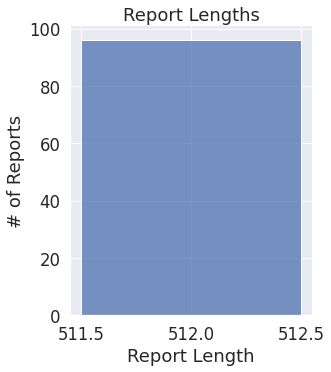

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

sns.set(style = 'darkgrid')

# Increase the plot size and font size
sns.set(font_scale = 1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Truncate any report lengths greater than 512
lengths = [min(l,512) for l in lengths]

# Plot the distribution of comment lengths
sns.displot(lengths, kde=False, rug=False)

plt.title("Report Lengths")
plt.xlabel("Report Length")
plt.ylabel("# of Reports")


How many data (reports) could be faulty? 

In [ ]:
# Count the number of suspicious reports that didn't not have full text extracted 
counter = 0
for l in lengths:
    if l<20:
        counter+=1
print('# of possible faulty reports: ', counter)


# of possible faulty reports:  0


How many reports run into the 512-token limit?

In [ ]:
# Count the number of sentences that had to be truncated to 512 tokens
num_truncated = lengths.count(512)

# Compare this to the total number of training reports
num_reports = len(lengths)
prcnt = float(num_truncated)/float(num_reports)

print('{:,} of {:,} sentences ({:.1%}) of corpus are longer than 512 tokens'.format(
        num_truncated, num_reports, prcnt))


96 of 96 sentences (100.0%) of corpus are longer than 512 tokens


## 3.3 Training and Validation Split


In [ ]:
# Load BertForSequenceClassification, the pre-trained BERT model with a 
# single linear classification layer on top.

from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab
        num_labels = num_labels, # the number of ourput labels -- 5 for five ArgumentLevel classification labels
        output_attentions = False, # whether the model returns attention weights
        output_hidden_states = False, # whether the model returns all hidden-states
)

# Tell pytorch to run this model on the GPU
model.cuda()



Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Create helper function
import numpy as np
import random
import time
import datetime


def flat_accuracy(preds, labels):
    '''
    Function to calculate the accuracy of our predictions vs labels
    '''
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Taks a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second
    elapsed_rounded = int(round(elapsed))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds = elapsed_rounded))

def to_dataframe(dict):
    # Display floats with two decimal places.
    pd.set_option('precision', 3)
    df_stats = pd.DataFrame(data=dict)
    df_stats = df_stats.set_index('epoch')
    # A hack to force the column headers to wrap.
    # df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
    return df_stats

In [ ]:
import numpy as np
import random
from torch.utils.data import TensorDataset, random_split
from tensorflow.python.ops.variables import validate_synchronization_aggregation_trainable
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup


# define a function for train-validation data splitting
def train_val_split(dataset, ratio):
    '''
    # Create a ratio:(1-ratio) train-validation split
    
    dataset: tensor object
    ratio: float <1 and >0
    '''
    # Calculate the number of samples to include in each set
    train_size = int(ratio * len(dataset))
    val_size = len(dataset) - train_size

    # Divide the dataset by randomly selecting samples
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))
    
    return train_dataset, val_dataset



# Create the DataLoaders for our training and validation sets.
def data_loader(train_dataset, val_dataset,
                batch_size):

    # We'll take training samples in random order
    train_dataloader = DataLoader(
                        train_dataset,                  # the trainig samples
                        sampler = RandomSampler(train_dataset), # select batches randomly
                        batch_size = batch_size,        # trains with this batch size
    )

    # For validation the order doesn't matter, so we'll just read them sequentially
    validation_dataloader = DataLoader(
                        val_dataset,                # the validation samples
                        sampler = SequentialSampler(val_dataset), # Pull out batches sequentially
                        batch_size = batch_size     # evaluate with this batch size
    )
    return train_dataloader, validation_dataloader



In [ ]:
def runner(training_ratio):
    # settings
    r = training_ratio
    batch_size = 16 # CUDA out of memory if using 32


    # Combine the training inputs into a TensorDataset
    dataset = TensorDataset(input_ids, attention_masks, labels)
    # split data
    train_dataset, val_dataset = train_val_split(dataset, r)
    # format data
    train_dataloader, validation_dataloader = data_loader(train_dataset, 
                                                        val_dataset,
                                                        batch_size)



    # ======================================================
    # Main - hyperparameters
    # ======================================================
    # Create optimiser
    optimizer = AdamW(model.parameters(),
                    lr = 2e-5,  # args.learning rate - default is 5e-5
                    eps = 1e-8, # args.adam_epsilon - default is 1e-8
    )

    # Number of training epochs. The BERT authors recommended between 2 and 4. 
    epochs = 4

    # Total number of training steps is [number of batches] x [number of epochs]
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler. # 学习率预热
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps,
                                                )



    # ======================================================
    # MAIN - Training loop
    # ======================================================
    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()



    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. 
        model.train()



        # For each batch of training data... 
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:

                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. 
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # Specifically, we'll get the loss (because we provided labels) and the
            # "logits"-- the model outputs prior to activation.
            result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        return_dict=True)

            loss = result.loss
            logits = result.logits

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. 
            total_train_loss += loss.item() # Tensor containing a single value

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate
            scheduler.step()


        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))






        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                result = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

            # Get the loss and "logits" output by the model. The "logits" are the 
            # output values prior to applying an activation function like the 
            # softmax.
            loss = result.loss
            logits = result.logits
                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))




        # ========================================
        #               Results
        # ========================================
        # Record all statistics from this epoch.
        training_stats.append(
            {
                'Run Number': 0,
                'Training ratio': r,
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time,
            }
        )
        df = to_dataframe(training_stats)

        print("")
        print("Training complete!")

        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    return df


In [ ]:
# test
# df = runner(0.5)

   48 training samples
   48 validation samples

======== Epoch 1 / 4 ========
Training...


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
# set the number of loops 
run_num = 10
# set training data ratio
ratios = [0.9]
for r in ratios:

    # create a dataframe to saveto
    final_df = pd.DataFrame()
    
    for counter in range(run_num):
        print('========= Running...=============')
        print('=== ratio: '+str(r)+', run_num:'+str(counter)+'===')

        df = runner(r)
        # count 'Run Number'
        df['Run Number'] = counter
        # append to the final dataframe
        final_df = pd.concat([df, final_df])
        
    # save dataframe
    print(final_df) 
    filepath = './Pickledfiles/bert_reasoninglevel/'+str(r)+'trainratio_'+str(run_num)+'runs_'+'4epochs.pkl'
    final_df.to_pickle(filepath)



========= Running...=============
=== ratio: 0.9, run_num:0===
   86 training samples
   10 validation samples

======== Epoch 1 / 4 ========
Training...

  Average training loss: 1.17
  Training epcoh took: 0:00:08

Running Validation...
  Accuracy: 0.50
  Validation Loss: 1.13
  Validation took: 0:00:00

Training complete!
Total training took 0:00:08 (h:mm:ss)

======== Epoch 2 / 4 ========
Training...

  Average training loss: 1.06
  Training epcoh took: 0:00:08

Running Validation...
  Accuracy: 0.50
  Validation Loss: 1.13
  Validation took: 0:00:00

Training complete!
Total training took 0:00:16 (h:mm:ss)

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.99
  Training epcoh took: 0:00:08

Running Validation...
  Accuracy: 0.50
  Validation Loss: 1.11
  Validation took: 0:00:00

Training complete!
Total training took 0:00:24 (h:mm:ss)

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.95
  Training epcoh took: 0:00:08

Running Validation...

In [ ]:
df = pd.read_pickle(r'./Pickledfiles/bert_reasoninglevel/0.5trainratio_1runs.pkl')
print(df)

       Run Number  Training ratio  Training Loss  Valid. Loss  Valid. Accur.  \
epoch                                                                          
1               0             0.5      5.948e-05    2.286e-05            1.0   
2               0             0.5      3.409e-05    2.309e-05            1.0   

      Training Time Validation Time  
epoch                                
1           0:00:04         0:00:02  
2           0:00:04         0:00:02  


# OLD CODE

In [ ]:
# ======================================================
# MAIN
# ======================================================
# Combine the training inputs into a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)
ratios = [0.5, 0.6, 0.7, 0.8, 0.9]


# loop training for each training-test ratios
for r in ratios:

    batch_size = 16 # CUDA out of memory if using 32
    
    # split data
    train_dataset, val_dataset = train_val_split(dataset, r)
    # format data
    train_dataloader, validation_dataloader = data_loader(train_dataset, 
                                                          val_dataset,
                                                          batch_size)



    # ======================================================
    # Main - hyperparameters
    # ======================================================
    # Create optimiser
    optimizer = AdamW(model.parameters(),
                    lr = 2e-5,  # args.learning rate - default is 5e-5
                    eps = 1e-8, # args.adam_epsilon - default is 1e-8
    )

    # Number of training epochs. The BERT authors recommended between 2 and 4. 
    epochs = 2
  
    # Total number of training steps is [number of batches] x [number of epochs]
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler. # 学习率预热
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps,
                                                )



    # ======================================================
    # MAIN - Training loop
    # ======================================================
    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()



    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. 
        model.train()



        # For each batch of training data... 
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:

                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. 
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # Specifically, we'll get the loss (because we provided labels) and the
            # "logits"-- the model outputs prior to activation.
            result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        return_dict=True)

            loss = result.loss
            logits = result.logits

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. 
            total_train_loss += loss.item() # Tensor containing a single value

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate
            scheduler.step()


        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))






        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                result = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

            # Get the loss and "logits" output by the model. The "logits" are the 
            # output values prior to applying an activation function like the 
            # softmax.
            loss = result.loss
            logits = result.logits
                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))





        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

        # save dataframe
        df = to_dataframe(training_stats)
        filepath = 'Pickledfiles/bert_reasoninglevel_trainratio'+str(r)+'_epochs'+str(epochs)+'_seedval42'+'_batchsize16'
        df.to_pickle(filepath)

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

   48 training samples
   48 validation samples

======== Epoch 1 / 10 ========
Training...


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



  Average training loss: 1.19
  Training epcoh took: 0:00:07

Running Validation...
  Accuracy: 0.62
  Validation Loss: 1.01
  Validation took: 0:00:02

======== Epoch 2 / 10 ========
Training...

  Average training loss: 1.11
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.62
  Validation Loss: 0.98
  Validation took: 0:00:02

======== Epoch 3 / 10 ========
Training...

  Average training loss: 1.07
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.60
  Validation Loss: 0.99
  Validation took: 0:00:02

======== Epoch 4 / 10 ========
Training...

  Average training loss: 0.97
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.58
  Validation Loss: 1.03
  Validation took: 0:00:02

======== Epoch 5 / 10 ========
Training...

  Average training loss: 0.92
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.60
  Validation Loss: 0.98
  Validation took: 0:00:02

======== Epoch 6 / 10 ========
Training...

  Average trai


4.3 Training loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

Training: 
* Unpack our data inputs and labels 
* Load data onto GPU for acceleration
* Clear out the gradients calculated in the previous pass
    * In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
* Forward pass (feed input data through the network)
* Backward pass (backpropagation)
* Tell the network to update parameters with optimizer.step()
* Track variables for minitoring progress

Evaluation:
* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data through the network)
* Compute loss on our validation data and track variables for monitoring process


Pytorch hides all the detailed calculations from us, but we've commented the code to print out which of the above steps are happening on each line.

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Let's view the summary of the training process.

In [ ]:
import pandas as pd
ratios = [0.5,0.6,0.7,0.8,0.9]
validacc_list = []

for i in ratios:
    # path = 'Pickledfiles/bert_reasoninglevel_trainratio'+str(i)+'_epochs1_seedval42_batchsize16.pkl'
    df = pd.read_pickle('bert_reasoninglevel_trainratio0.5_epochs1_seedval42_batchsize16')
    validacc_list.append(df.iloc[0]['Valid. Accur.'])
    print(df)

print(validacc_list)

FileNotFoundError: ignored

In [ ]:
pip install git+https://github.com/garrettj403/SciencePlots

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

5. Performance on Test Set

5.1 Data Preparation

In [ ]:
# Create the DataLoader.
prediction_data = val_dataset
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = validation_dataloader

5.2 Evaluate on Test Set

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test reports...'.format(len(val_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches. 

Each batch has 32 sentences in it, except the last batch which has only (516 % 32) = 4 test sentences in it.


In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

In [ ]:
# Print the original report.
print('length:',len(corpus[0]),';  Original: ', corpus[0])

# Print the report split into tokens.
print('length:',len(tokenizer.tokenize(corpus[0])),';  Tokenized: ', tokenizer.tokenize(corpus[0]))

# Print the report mapped to token ids.
print('length:',len(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(corpus[0]))) , ';  Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(corpus[0])))

Let's apply the tokenizer to one report just to see the output.

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)